Importando bibliotecas e módulos implementados

In [1]:
# External libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy.signal import butter, lfilter

# Implemented modules
import optimize_tg
from optimize_tg import MSE
# Obs: modified version of the new_wave module
import new_wave_filt
from new_wave_filt import get_transition_points
from epid_model import model_daily, share_variables 

Carregando dados

In [2]:
# Import data
data = pd.read_csv("../Datasets/osaka.csv") 
city_name = 'Osaka' 
indicator='cases'

acc_data = data.cumulative_confirmed #(Japan)
normalized_acc_data = acc_data / max(acc_data)

t = np.linspace(0, len(acc_data)-1, len(acc_data))

normalized_acc_data = normalized_acc_data.tolist()
daily_data = data.new_confirmed

scaling_factor = 1000
acc_data = acc_data / scaling_factor
daily_data = list(daily_data/ scaling_factor)

Definindo condições iniciais de cada sigmoide no modelo

In [3]:
# Initial Conditions

def initial_cond_0(y_t):
    A0 = 2*max(y_t)
    tp0 = (2/3)*len(y_t)
    delta0 = (1/4)*len(y_t)
    nu0 = 1
    return [A0, tp0, delta0, nu0]

optimize_tg.initial_cond = initial_cond_0

def update_cond_nw(A0, tp0):
    # tp0 += 150 # Obs: ideal distance between sigmoids ~ 150 days 
    return [A0, tp0]
optimize_tg.update_cond = update_cond_nw

## Testando diferentes filtros

In [4]:
# Moving average filter
def moving_average(x, win_size):
    filtered = np.convolve(x, np.ones(win_size), 'valid') / win_size
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

# Median filter
def median_filter(x, win_size):
    S = 1
    nrows = ((x.size-win_size)//S)+1
    n = x.strides[0]
    strided = np.lib.stride_tricks.as_strided(x, shape=(nrows,win_size), strides=(S*n,n))
    filtered  = np.median(strided,axis=1)
    filtered = np.append(np.zeros(win_size-1), filtered) # fill the w-1 first slots with zeros
    return filtered

def butterworth_lowpass_filter(data, cutoff_freq, fs, order=2):
    #fs is the sampling rate
    nyq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    # lfilter apply filter along one dimension
    y = lfilter(b, a, data)
    return y

def filter_data(data):    

    plt.figure(figsize=(12, 6))
    plt.title(f"Teste 1 - Processo de filtragem - {city_name}")
    plt.xlabel("t (dias)")
    plt.ylabel("casos / dia")

    # Plotting unfiltered version
    plt.plot(data, label="sinal não filtrado", c='silver', linestyle='dashed')

    # Moving average with 14-day window
    filtered_data = moving_average(data, 14)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14])")
    
    # 2nd Order Low-Pass Filter with 14-day window
    order = 2
    fs = len(data) # sampling rate       
    cutoff = 14 # cutoff freq.
    filtered_data =  butterworth_lowpass_filter(filtered_data, cutoff, fs, order)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14] + bw-passa-baixas)")

    # Median filter with 14-day window
    filtered_data = median_filter(filtered_data, 14)
    plt.plot(filtered_data, label="sinal filtrado (m.móvel[14] + bw-passa-baixas+ mediana[14])")

    # Reduce the delay effect introduced by the filtering process
    # Advance the signal by 25 days
    n_days_shift = 25
    filtered_data = filtered_data[n_days_shift:]    
    plt.plot(filtered_data, label=f"sinal filtrado e adiantado({n_days_shift} dias)")

    plt.legend()

    #plt.savefig(f'Figuras/TG_filtering_process_{city_name}.png', dpi=600)
    plt.show()

    return filtered_data

new_wave_filt.filter_data = filter_data

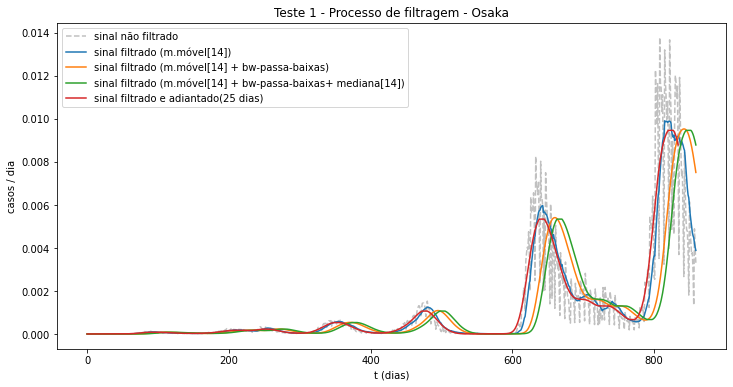

x_nw: [171, 233, 307, 418, 591]


In [5]:
# Transition Points
x_nw = get_transition_points(acc_data, visual=False, city_name=city_name, threshold=2e-6, indicator = indicator)
x_nw = x_nw[1:6]

print('x_nw:', x_nw)

/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #1 - A0:9.604505775681448 | tp0:99.55967201272018 | delta0:14.530978814658898 | nu0:1.0 
(optimal) Sigmoid #1 - A0:9.604505775681448 | tp0:99.55967201272018 | delta0:14.530978814658898 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #2 - A0:18.856975656555356 | tp0:207.54794426337844 | delta0:12.058179778530024 | nu0:1.0 
(optimal) Sigmoid #2 - A0:18.856975656555356 | tp0:207.54794426337844 | delta0:12.058179778530024 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #3 - A0:12.276142149342794 | tp0:255.31660719083726 | delta0:7.145355192020544 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #3 - A0:12.276142149342794 | tp0:255.31660719083726 | delta0:7.145355192020544 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #4 - A0:54.682132755250805 | tp0:351.0214974059127 | delta0:11.329618096352098 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #4 - A0:54.682132755250805 | tp0:351.0214974059127 | delta0:11.329618096352098 | nu0:1.0 
Sigmoid #5 - A0:99.34403297309407 | tp0:471.8831158836376 | delta0:10.470660149240906 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


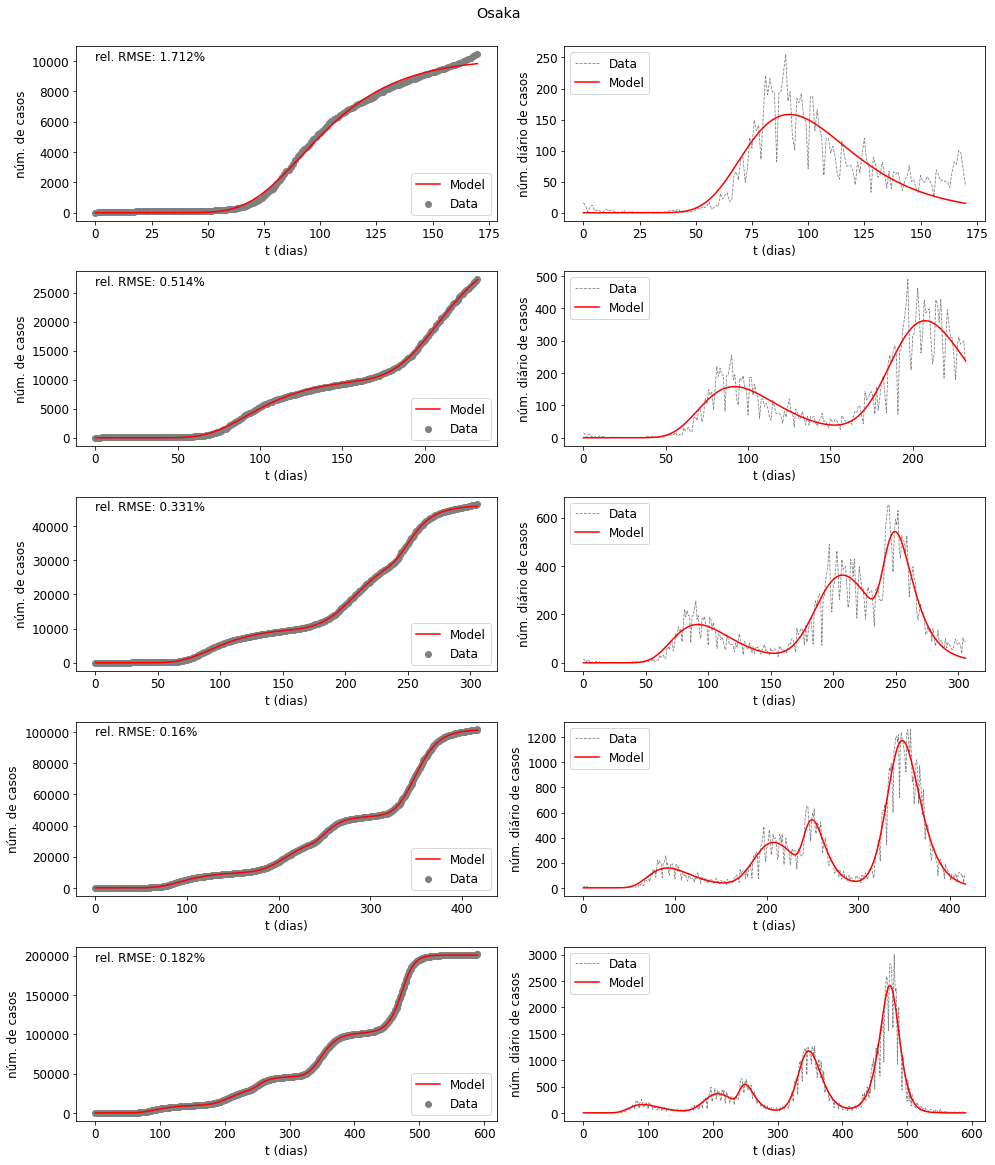

In [6]:
sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor,
                               visual=True
                            )

#plot_first_wave(x_nw, sig_params, daily_data)

Sigmoid #1 - A0:7.65016371127552 | tp0:91.56970337193101 | delta0:9.753228916674084 | nu0:1.0 
(optimal) Sigmoid #1 - A0:7.65016371127552 | tp0:91.56970337193101 | delta0:9.753228916674084 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in exp
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


Sigmoid #2 - A0:26.892399411220843 | tp0:213.61075396826215 | delta0:18.96159063785416 | nu0:1.0 
(optimal) Sigmoid #2 - A0:26.892399411220843 | tp0:213.61075396826215 | delta0:18.96159063785416 | nu0:1.0 
Sigmoid #3 - A0:16.20588732711913 | tp0:255.03401913192388 | delta0:7.8478038930725775 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #3 - A0:16.20588732711913 | tp0:255.03401913192388 | delta0:7.8478038930725775 | nu0:1.0 
Sigmoid #4 - A0:54.85191243171717 | tp0:350.9698578904761 | delta0:11.36325543162998 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))
/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:10: RuntimeWarning: overflow encountered in double_scalars
  return A / ((1 + nu * np.exp(-1*(t - tp)/(delta)))**(1/nu))


(optimal) Sigmoid #4 - A0:54.85191243171717 | tp0:350.9698578904761 | delta0:11.36325543162998 | nu0:1.0 
Sigmoid #5 - A0:99.35117805101649 | tp0:471.8811428976726 | delta0:10.47182261396063 | nu0:1.0 


/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


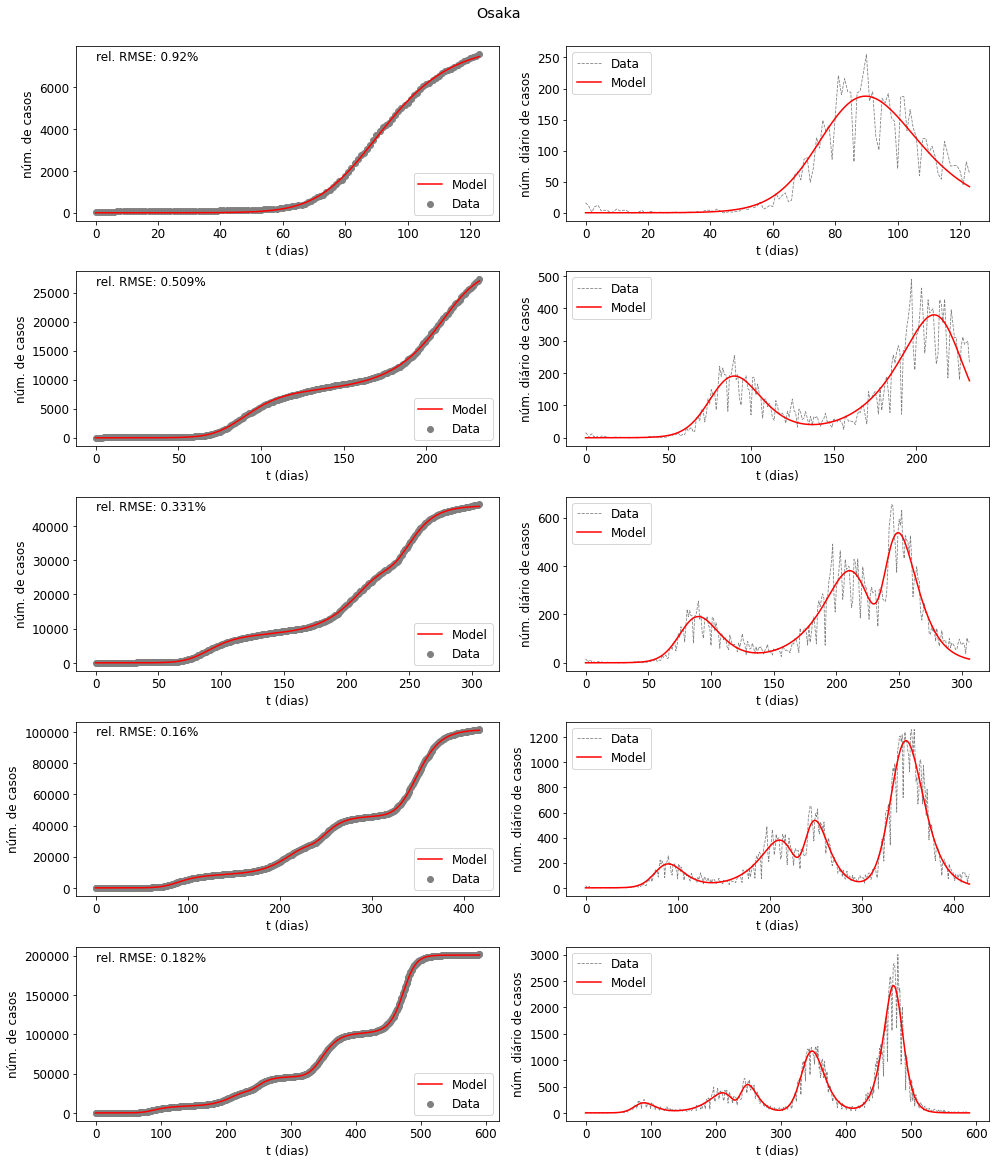

In [7]:
x_nw = [124, 233, 307, 418, 591] 
sig_params, rel_rmse_list = optimize_tg.fit_data(acc_data, 
                               daily_data, 
                               city_name, 
                               x_nw, 
                               indicator = indicator, 
                               n_weeks_pred = 0,
                               scaling_factor = scaling_factor,
                               visual=True
                            )

/home/fpelogia/Documentos/HMP/Implementações/Python/TG_rascunho/epid_model.py:20: RuntimeWarning: overflow encountered in double_scalars
  return (A * g(t))/(delta * (1 + nu*g(t))**((nu+1)/nu))


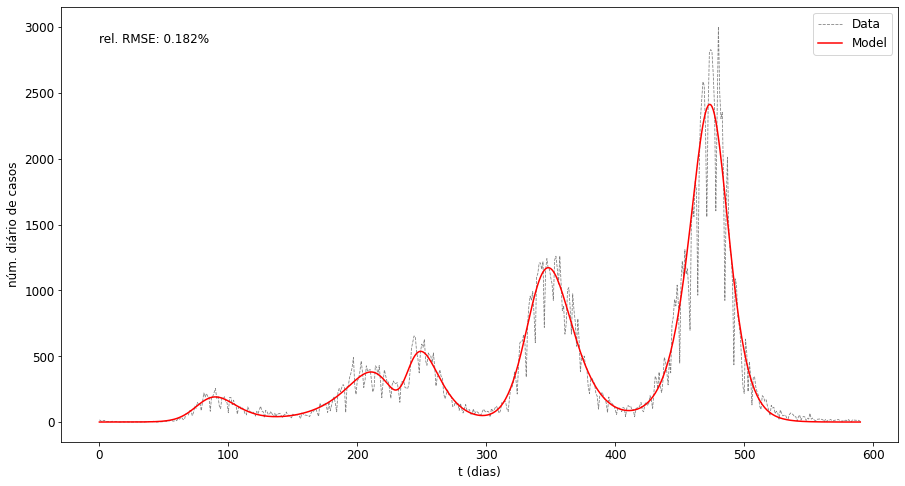

In [9]:
percent_fmt = np.vectorize(lambda x: float(x[:-1])/100)

fig = plt.figure(figsize=(15,8))
n_sig = 5
n_days = x_nw[4]
[A, tp, delta, nu] = sig_params[4]
share_variables(n_days, n_sig, sig_params)
y_m_daily = model_daily(t, A, tp, delta, nu)[:n_days]
plt.plot(scaling_factor * np.array(daily_data[:n_days]), label="Data", c='gray', lw=0.8, linestyle='dashed')
plt.plot(scaling_factor * np.array(y_m_daily), label='Model', c='r')
plt.xlabel('t (dias)')
plt.ylabel(f'núm. diário de casos')
plt.legend(loc=1) # upper left  
rel_rmse = percent_fmt(rel_rmse_list[4])
plt.text(0, scaling_factor * 0.96 * max(daily_data[:n_days]), f'rel. RMSE: {round(100*rel_rmse, 3)}%')
plt.show()

In [10]:
A_list = []
tp_list = []
delta_list = []
nu_list = []
for i, par_sig_i in zip(range(len(sig_params)), sig_params):
    print(f'Parameters Sigmoid {i}: {par_sig_i}')
    [A, tp, delta, nu] = par_sig_i
    A_list.append(round(A))
    tp_list.append(round(tp))
    delta_list.append(round(delta, 1))
    nu_list.append(round(nu, 3))

data_dict = {
    r'Sigmoid Number':range(len(sig_params)),
    r'A': A_list,
    r'$t_p$': tp_list,
    r'$\nu$': nu_list,
    r'$\delta$': delta_list,
}

df_params = pd.DataFrame(data_dict)
df_params.to_excel(f'Parameters_{city_name}.xlsx')


Parameters Sigmoid 0: [8.02727420694301, 89.7174761821567, 12.840850345531422, 0.46481973893463713]
Parameters Sigmoid 1: [21.091321361189138, 210.58877325428458, 10.046976653326325, 2.277516175838617]
Parameters Sigmoid 2: [16.794322686122474, 250.30701152000324, 12.414518738045068, 0.001000000000000051]
Parameters Sigmoid 3: [55.77329954671773, 348.0651060908915, 14.169230276357169, 0.48655799790004933]
Parameters Sigmoid 4: [99.09902461015841, 473.31741781427786, 9.35908643414503, 1.3178673633905578]


In [11]:
df_params

,Sigmoid Number,A,$t_p$,$\nu$,$\delta$
0,0,8,90,0.465,12.8
1,1,21,211,2.278,10.0
2,2,17,250,0.001,12.4
3,3,56,348,0.487,14.2
4,4,99,473,1.318,9.4
